In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [2]:
class OptimalMonetaryPolicy:
    
    def __init__(self, beta=0.99, sigma=6.0, kappa=0.024, 
                 rho_u=0.35, rho_r=0.35, 
                 sigma_u=0.17, sigma_r=13.8,
                 lambda_x=0.048, lambda_i=0.236):
        """
        Initialize model parameters
        """
        self.beta = beta
        self.sigma = sigma
        self.kappa = kappa
        self.rho_u = rho_u
        self.rho_r = rho_r
        self.sigma_u = sigma_u
        self.sigma_r = sigma_r
        self.lambda_x = lambda_x
        self.lambda_i = lambda_i
        
        # Set up state space matrices
        self._setup_matrices()
        
    def _setup_matrices(self):
        """Set up state space matrices"""
        # State vector st = [πt, xt, ut, rt^n]
        
        # Construct A matrix
        self.A = np.array([
            [1/self.beta, -self.kappa/self.beta, 1/self.beta, 0],
            [-self.sigma/self.beta, (self.beta+self.kappa*self.sigma)/self.beta, self.sigma/self.beta, -self.sigma],
            [0, 0, self.rho_u, 0],
            [0, 0, 0, self.rho_r]
        ])
        
        # Construct B matrix
        self.B = np.array([[0], [self.sigma], [0], [0]])
        
        # Shock covariance matrix
        self.Sigma = np.array([
            [0, 0],
            [0, 0],
            [self.sigma_u, 0],
            [0, self.sigma_r]
        ])
        
        # Loss function weight matrix
        self.Q = np.diag([1, self.lambda_x, 0, 0])
        
        # Interest rate penalty matrix
        self.R = np.array([[self.lambda_i]])
    
    def solve_optimal_policy(self):
        """Solve for optimal Taylor rule"""
        # Solve discrete-time algebraic Riccati equation
        P = solve_discrete_are(self.A, self.B, self.Q, self.R)
        
        # Calculate optimal feedback gain
        F = -np.linalg.inv(self.R + self.B.T @ P @ self.B) @ self.B.T @ P @ self.A
        
        # Extract corresponding Taylor rule coefficients
        phi_pi = F[0, 0]  # Response to inflation
        phi_x = F[0, 1]   # Response to output gap
        phi_u = F[0, 2]   # Response to cost-push shock
        phi_r = F[0, 3]   # Response to demand shock
        
        return {
            'P': P,
            'F': F,
            'phi_pi': phi_pi,
            'phi_x': phi_x,
            'phi_u': phi_u,
            'phi_r': phi_r
        }
    
    def impulse_responses(self, shock_type, periods=20):
        """
        Calculate impulse responses under optimal policy
        """
        # First solve for optimal policy
        policy = self.solve_optimal_policy()
        F = policy['F']
        
        # Closed-loop system matrix under optimal policy
        A_closed = self.A + self.B @ F
        
        # Initial state
        s0 = np.zeros(4)
        if shock_type == 'cost':
            s0[2] = 1.0  # Unit cost-push shock
        elif shock_type == 'demand':
            s0[3] = 1.0  # Unit demand shock
        else:
            raise ValueError("shock_type must be 'cost' or 'demand'")
        
        # Evolution of state variables
        states = np.zeros((periods, 4))
        states[0] = s0
        
        for t in range(1, periods):
            states[t] = A_closed @ states[t-1]
        
        # Calculate interest rates
        interest_rates = np.zeros(periods)
        for t in range(periods):
            interest_rates[t] = F @ states[t]
        
        # Create DataFrame
        df = pd.DataFrame({
            'period': range(periods),
            'inflation': states[:, 0],
            'output_gap': states[:, 1],
            'interest_rate': interest_rates
        })
        
        return df
    
    def plot_impulse_responses(self, save_fig=False):
        """Plot impulse responses under optimal policy"""
        # Get impulse response data
        df_cost = self.impulse_responses('cost')
        df_demand = self.impulse_responses('demand')
        
        # Create a 2x3 grid of plots
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 3, figure=fig)
        
        # Responses to cost-push shock
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(df_cost['period'], df_cost['inflation'], 'b-', linewidth=2)
        ax1.set_title('Inflation Response to Cost-Push Shock')
        ax1.set_xlabel('Periods')
        ax1.grid(True)
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(df_cost['period'], df_cost['output_gap'], 'g-', linewidth=2)
        ax2.set_title('Output Gap Response to Cost-Push Shock')
        ax2.set_xlabel('Periods')
        ax2.grid(True)
        
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.plot(df_cost['period'], df_cost['interest_rate'], 'r-', linewidth=2)
        ax3.set_title('Interest Rate Response to Cost-Push Shock')
        ax3.set_xlabel('Periods')
        ax3.grid(True)
        
        # Responses to demand shock
        ax4 = fig.add_subplot(gs[1, 0])
        ax4.plot(df_demand['period'], df_demand['inflation'], 'b-', linewidth=2)
        ax4.set_title('Inflation Response to Demand Shock')
        ax4.set_xlabel('Periods')
        ax4.grid(True)
        
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.plot(df_demand['period'], df_demand['output_gap'], 'g-', linewidth=2)
        ax5.set_title('Output Gap Response to Demand Shock')
        ax5.set_xlabel('Periods')
        ax5.grid(True)
        
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.plot(df_demand['period'], df_demand['interest_rate'], 'r-', linewidth=2)
        ax6.set_title('Interest Rate Response to Demand Shock')
        ax6.set_xlabel('Periods')
        ax6.grid(True)
        
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('optimal_impulse_responses.png', dpi=300, bbox_inches='tight')
        
        return fig
    
    def parameter_sensitivity(self, parameter_name, values, save_fig=False):
        """
        Analyze parameter sensitivity
        """
        # Validate parameter name
        valid_params = ['sigma', 'rho_u', 'rho_r', 'lambda_x', 'lambda_i']
        if parameter_name not in valid_params:
            raise ValueError(f"parameter_name must be one of {valid_params}")
        
        # Store results for different parameter values
        results = {'parameter_value': values, 'phi_pi': [], 'phi_x': []}
        
        # Save original parameter value
        original_value = getattr(self, parameter_name)
        
        # Solve for each parameter value
        for value in values:
            # Update parameter
            setattr(self, parameter_name, value)
            
            # Reset matrices
            self._setup_matrices()
            
            # Solve for optimal policy
            policy = self.solve_optimal_policy()
            
            # Store results
            results['phi_pi'].append(policy['phi_pi'])
            results['phi_x'].append(policy['phi_x'])
        
        # Restore original parameter value
        setattr(self, parameter_name, original_value)
        self._setup_matrices()
        
        # Create DataFrame
        df = pd.DataFrame(results)
        
        # Plot parameter sensitivity
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(values, results['phi_pi'], 'bo-', linewidth=2)
        ax1.set_xlabel(f'{parameter_name}')
        ax1.set_ylabel('φπ (Inflation Coefficient)')
        ax1.set_title(f'Sensitivity of φπ to {parameter_name}')
        ax1.grid(True)
        
        ax2.plot(values, results['phi_x'], 'ro-', linewidth=2)
        ax2.set_xlabel(f'{parameter_name}')
        ax2.set_ylabel('φx (Output Gap Coefficient)')
        ax2.set_title(f'Sensitivity of φx to {parameter_name}')
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_fig:
            plt.savefig(f'sensitivity_{parameter_name}.png', dpi=300, bbox_inches='tight')
        
        return df, fig

    def analyze_all_parameters(self, save_figs=False):
        """Analyze sensitivity of all key parameters"""
        # Define range of values for each parameter
        parameter_ranges = {
            'sigma': [1.0, 3.0, 6.0, 9.0, 12.0],
            'rho_u': [0.1, 0.2, 0.35, 0.5, 0.7],
            'rho_r': [0.1, 0.2, 0.35, 0.5, 0.7],
            'lambda_x': [0.01, 0.048, 0.1, 0.5, 1.0],
            'lambda_i': [0.05, 0.1, 0.236, 0.5, 1.0]
        }
        
        # Store results for all parameters
        all_results = {}
        all_figures = {}
        
        # Perform sensitivity analysis for each parameter
        for param, values in parameter_ranges.items():
            df, fig = self.parameter_sensitivity(param, values, save_fig=save_figs)
            all_results[param] = df
            all_figures[param] = fig
        
        return all_results, all_figures

最优泰勒规则系数:
φπ (通胀系数) = 1.7790
φx (产出缺口系数) = -0.1940
φu (成本推动冲击系数) = 0.2818
φr (需求冲击系数) = 0.9486


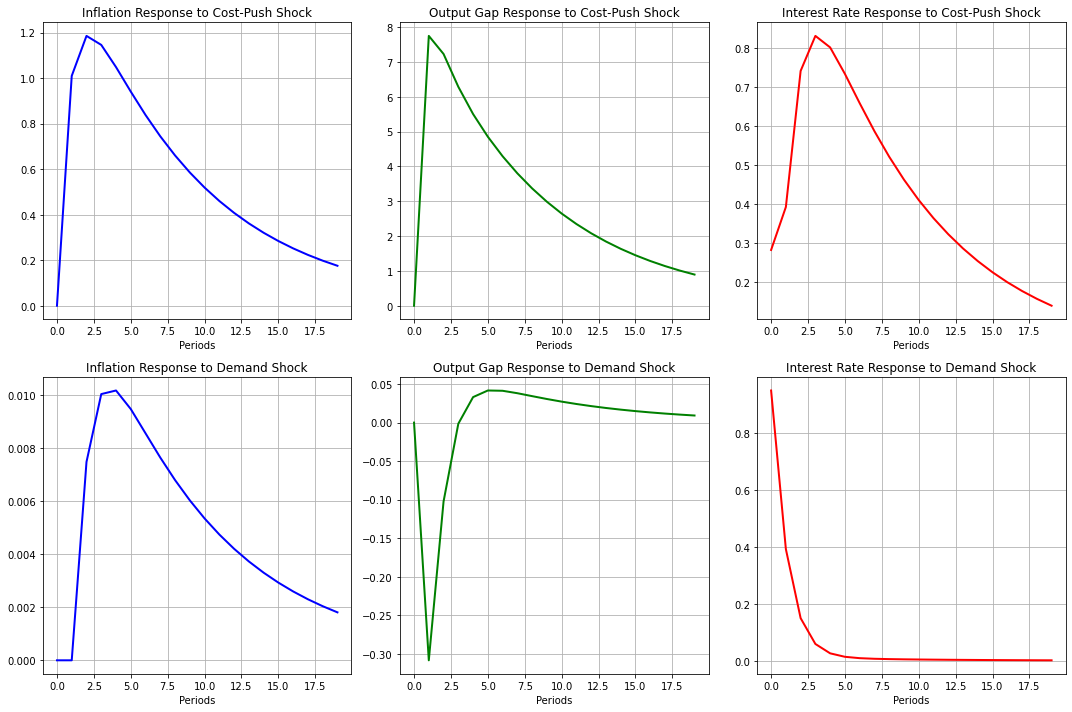

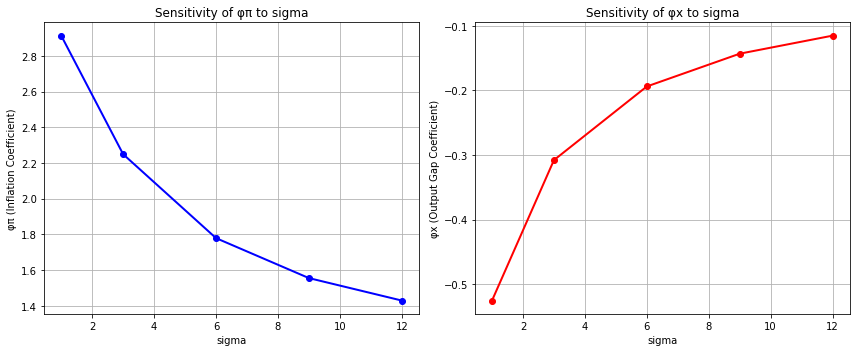

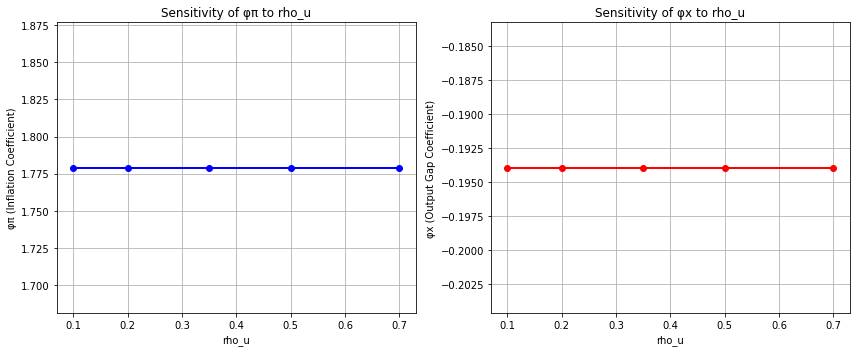

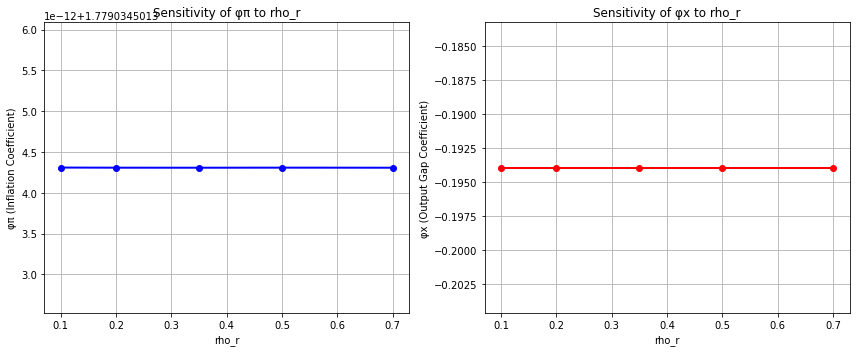

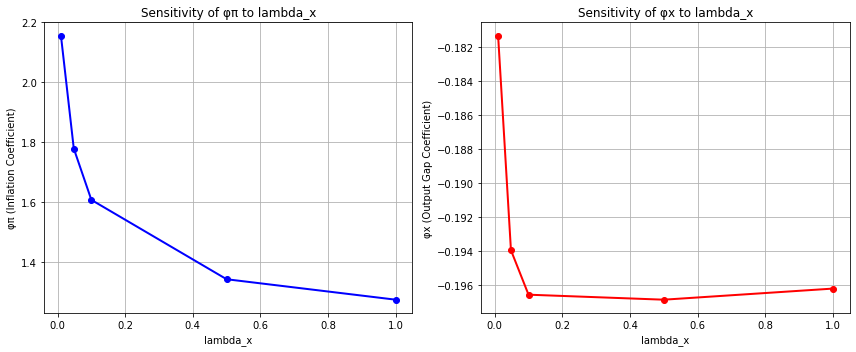

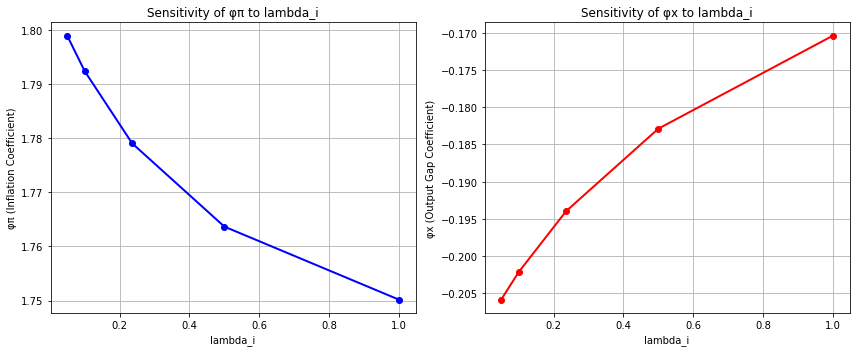

In [3]:
# Main program
if __name__ == "__main__":
    # Create model instance
    model = OptimalMonetaryPolicy()
    
    # 1. Solve for optimal coefficients
    policy = model.solve_optimal_policy()
    print("Optimal Taylor rule coefficients:")
    print(f"φπ (Inflation coefficient) = {policy['phi_pi']:.4f}")
    print(f"φx (Output gap coefficient) = {policy['phi_x']:.4f}")
    print(f"φu (Cost-push shock coefficient) = {policy['phi_u']:.4f}")
    print(f"φr (Demand shock coefficient) = {policy['phi_r']:.4f}")
    
    # 2. Plot central bank's optimal responses to shocks
    fig_responses = model.plot_impulse_responses(save_fig=True)
    
    # 3. Analyze the impact of parameter changes on results
    all_results, all_figures = model.analyze_all_parameters(save_figs=True)
    
    plt.show()

In [4]:
all_results

{'sigma':    parameter_value    phi_pi     phi_x
 0              1.0  2.913652 -0.525128
 1              3.0  2.249147 -0.307888
 2              6.0  1.779035 -0.193953
 3              9.0  1.555095 -0.143261
 4             12.0  1.429189 -0.115338,
 'rho_u':    parameter_value    phi_pi     phi_x
 0             0.10  1.779035 -0.193953
 1             0.20  1.779035 -0.193953
 2             0.35  1.779035 -0.193953
 3             0.50  1.779035 -0.193953
 4             0.70  1.779035 -0.193953,
 'rho_r':    parameter_value    phi_pi     phi_x
 0             0.10  1.779035 -0.193953
 1             0.20  1.779035 -0.193953
 2             0.35  1.779035 -0.193953
 3             0.50  1.779035 -0.193953
 4             0.70  1.779035 -0.193953,
 'lambda_x':    parameter_value    phi_pi     phi_x
 0            0.010  2.156194 -0.181304
 1            0.048  1.779035 -0.193953
 2            0.100  1.607643 -0.196576
 3            0.500  1.342671 -0.196871
 4            1.000  1.274411 -0.19621